# Assignment 2: Machine Learning Pipeline  
Yanning Cui

In [184]:
import pandas as pd
import numpy as np
import glob
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import pylab as pl

%matplotlib inline

### 1. Read Data: For this assignment, assume input is CSV and write a function that can read a csv into python

In [89]:
def read_csv(filepath):
   "This function reads a csv file into Python"
   df = pd.read_csv(filepath)
   return df

In [90]:
raw_df = read_csv("./data/credit-data.csv")
raw_df.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0


### 2. Explore Data: You can use the code you wrote for assignment 1 here to generate distributions and data summaries

#### 2.1 What percentage of people 'go bad' in 2 years?

In [5]:
raw_df.SeriousDlqin2yrs.mean()

0.06684

#### *About 6.684% of people will  experience financial distress in the next two years.*

#### 2.2 Distribution of neighborhoods in different age groups among those who experience financial distress in the next two years

In [28]:
#define a function to generate age groups
def agegroup(df):
    labels = [ "{0} - {1}".format(i, i + 9) for i in range(0, 110, 10) ]
    agegroup = pd.cut(df, range(0, 115, 10), right=False, labels=labels)
    return agegroup

In [29]:
#apply agegroup function
raw_df['agegroup'] = raw_df[['age']].apply(agegroup)

In [32]:
#group by neighborhood and age group
distress_zip = raw_df[raw_df['zipcode'].notnull() & (raw_df['SeriousDlqin2yrs'] == 1)].groupby(["zipcode", "agegroup"]).size().reset_index()
distress_zip['zipcode'].to_string()
distress_zip.columns = ['zipcode', 'agegroup', 'Count']
distress_zip.head()

,zipcode,agegroup,Count
0,60601,20 - 29,128
1,60601,30 - 39,231
2,60601,40 - 49,329
3,60601,50 - 59,249
4,60601,60 - 69,104


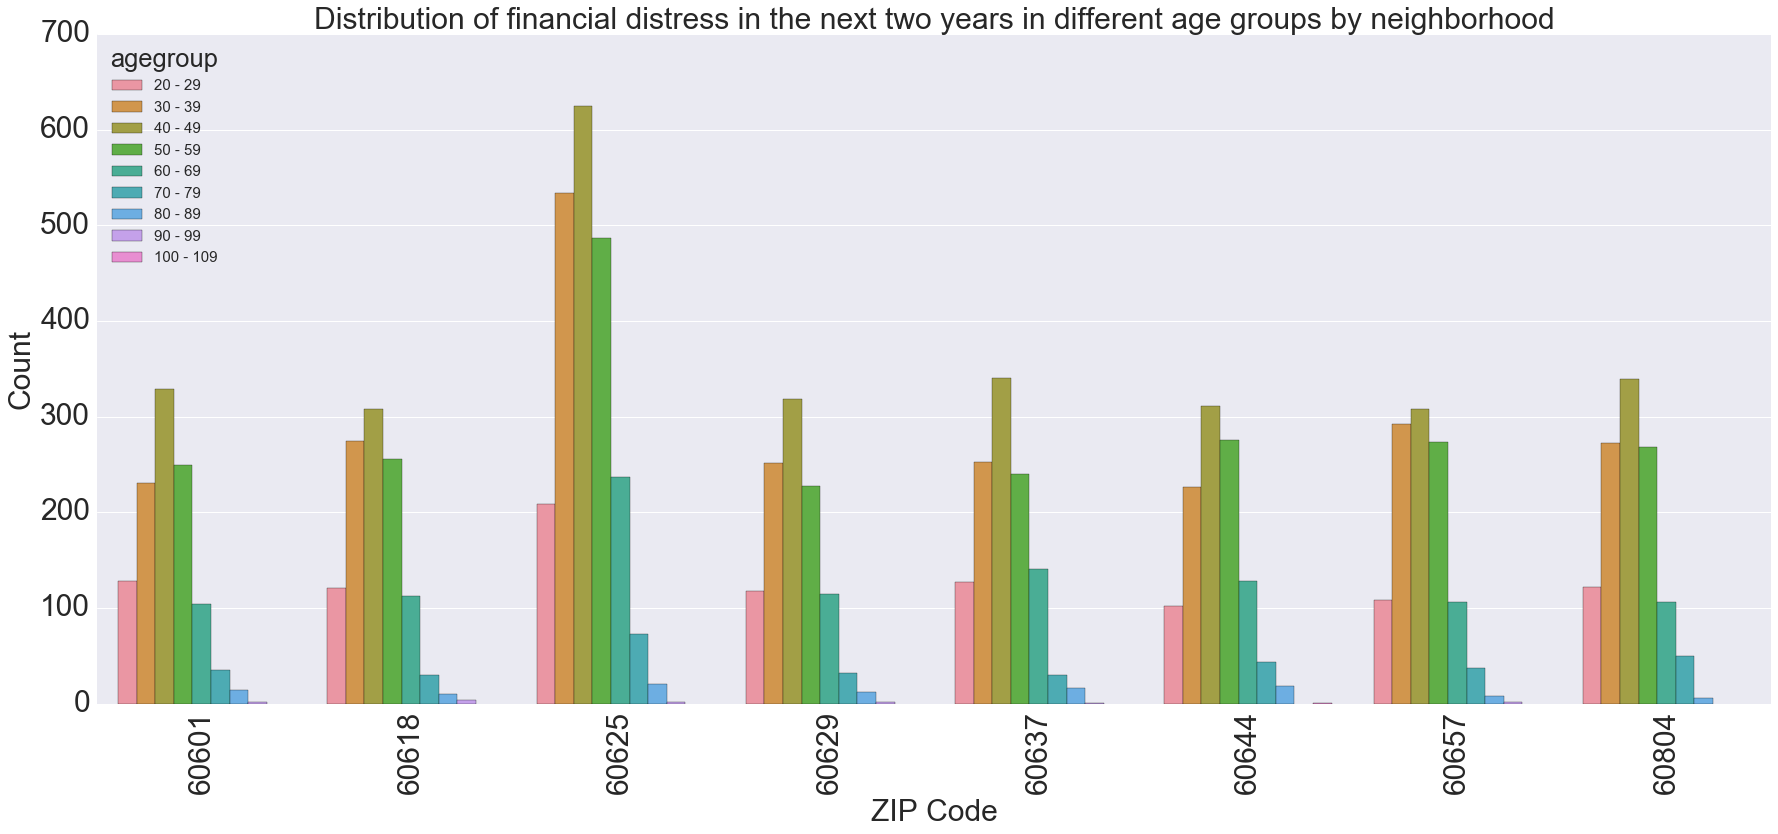

In [33]:
#visualize results
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 20, 'legend.fontsize': 15.0, 'axes.titlesize': 30, "figure.figsize": [30, 12]}
sns.set(rc=rc)
g = sns.barplot(ci = None, x = distress_zip["zipcode"], y = distress_zip['Count'], hue = distress_zip["agegroup"])
plt.xticks(rotation=90)
g.set(xlabel = "ZIP Code", ylabel = "Count", title = "Distribution of financial distress in the next two years in different age groups by neighborhood")

#### *People of 40-49 age group living in 60625 are the most likely to experience financial distress in the next two years. Generally, people aged between 40-49 are the most likely to have bad credits*

#### 2.3 Distribution of neighborhoods and monthly income in different families among those who experience financial distress in the next two years

In [10]:
#group by number of dependents
df_dependent = raw_df[raw_df['SeriousDlqin2yrs'] == 1].groupby(["NumberOfDependents"]).size().reset_index()
df_dependent.columns = ['NumberOfDependents', 'Count']
df_dependent

,NumberOfDependents,Count
0,0.0,5095
1,1.0,1935
2,2.0,1584
3,3.0,837
4,4.0,297
5,5.0,68
6,6.0,24
7,7.0,5
8,8.0,2


#### *Single women/men are the most likely to go bankrupt. People are less likely to experience financial distress if they have a bigger family.*

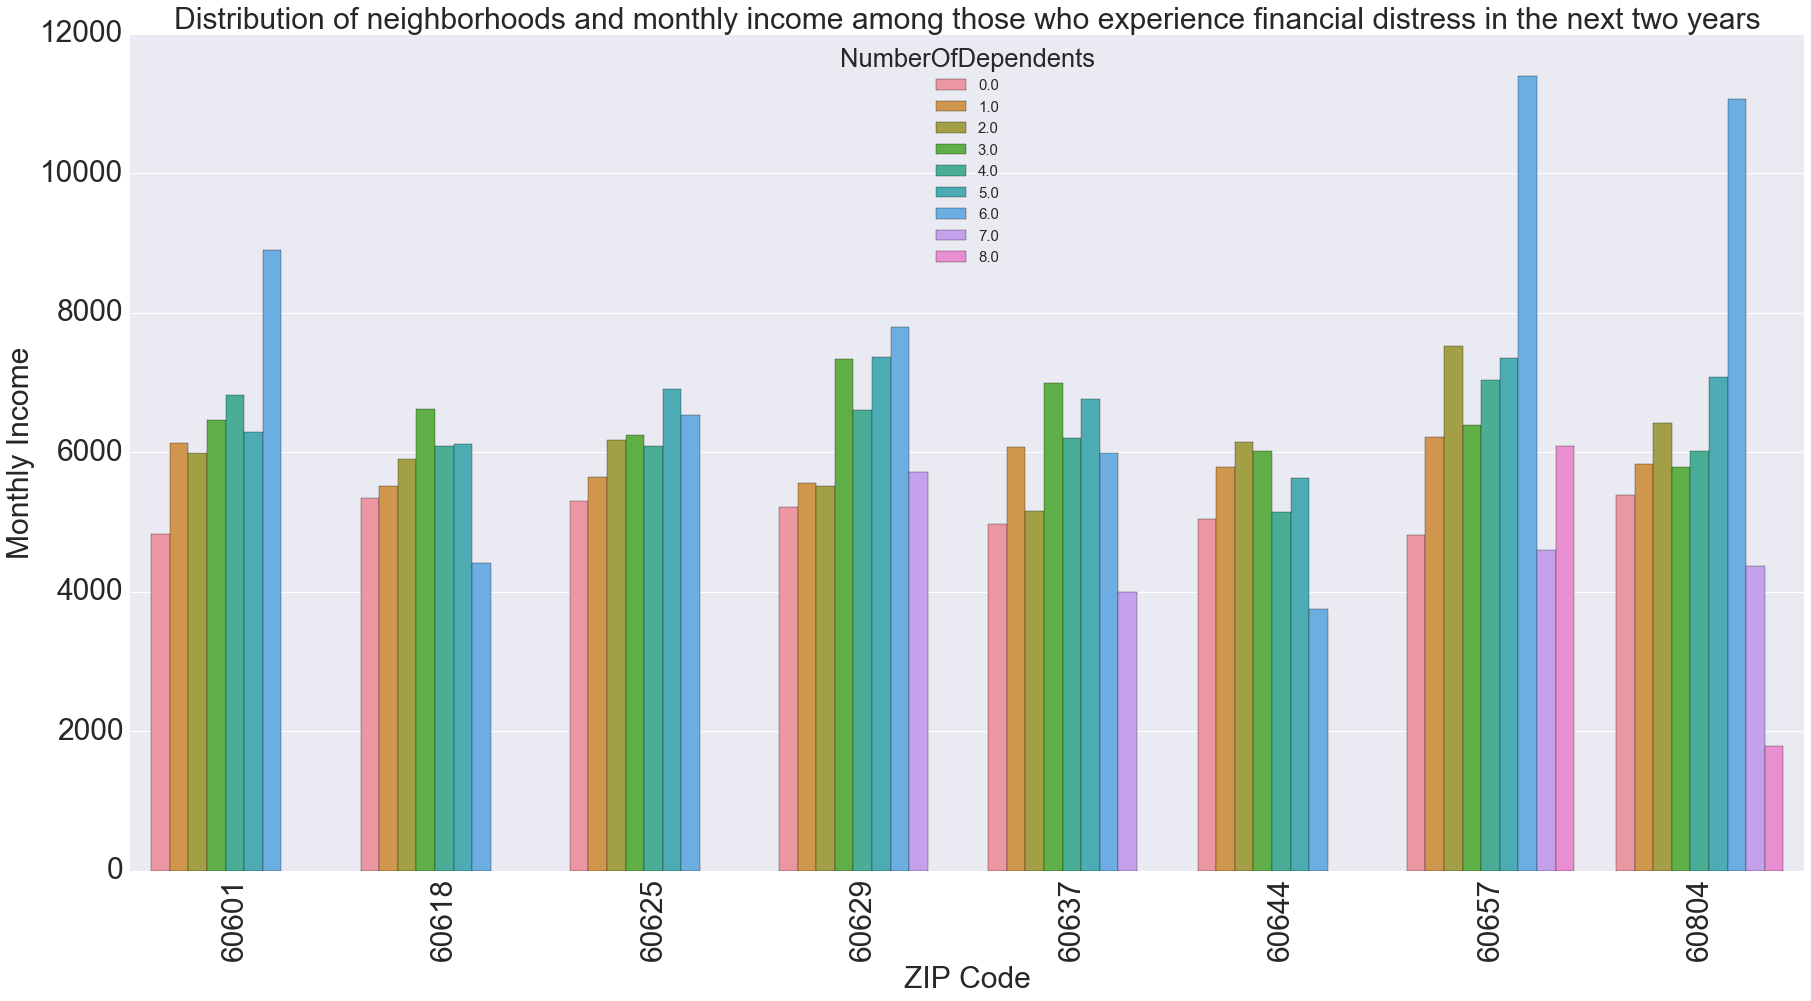

In [11]:
#visualize results
df_distress = raw_df[raw_df['SeriousDlqin2yrs'] == 1]
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 20, 'legend.fontsize': 15.0, 'axes.titlesize': 30, "figure.figsize": [30, 15]}
sns.set(rc=rc)
g = sns.barplot(ci = None, x = df_distress["zipcode"], y = df_distress['MonthlyIncome'], hue = df_distress["NumberOfDependents"])
plt.xticks(rotation=90)
g.set(xlabel = "ZIP Code", ylabel = "Monthly Income", title = "Distribution of neighborhoods and monthly income among those who experience financial distress in the next two years")

#### *Most of the people who experience financial distress earn less than $8,000 per month. Generally, families with 3-5 dependetns make more money in 60618, 60637, 60644, while families with 6 dependents make more money in 60601, 60657, 60804. Families with 7 or more dependents make the least money.* 

#### 2.4 Distribution of neighborhoods and monthly income for two groups of people

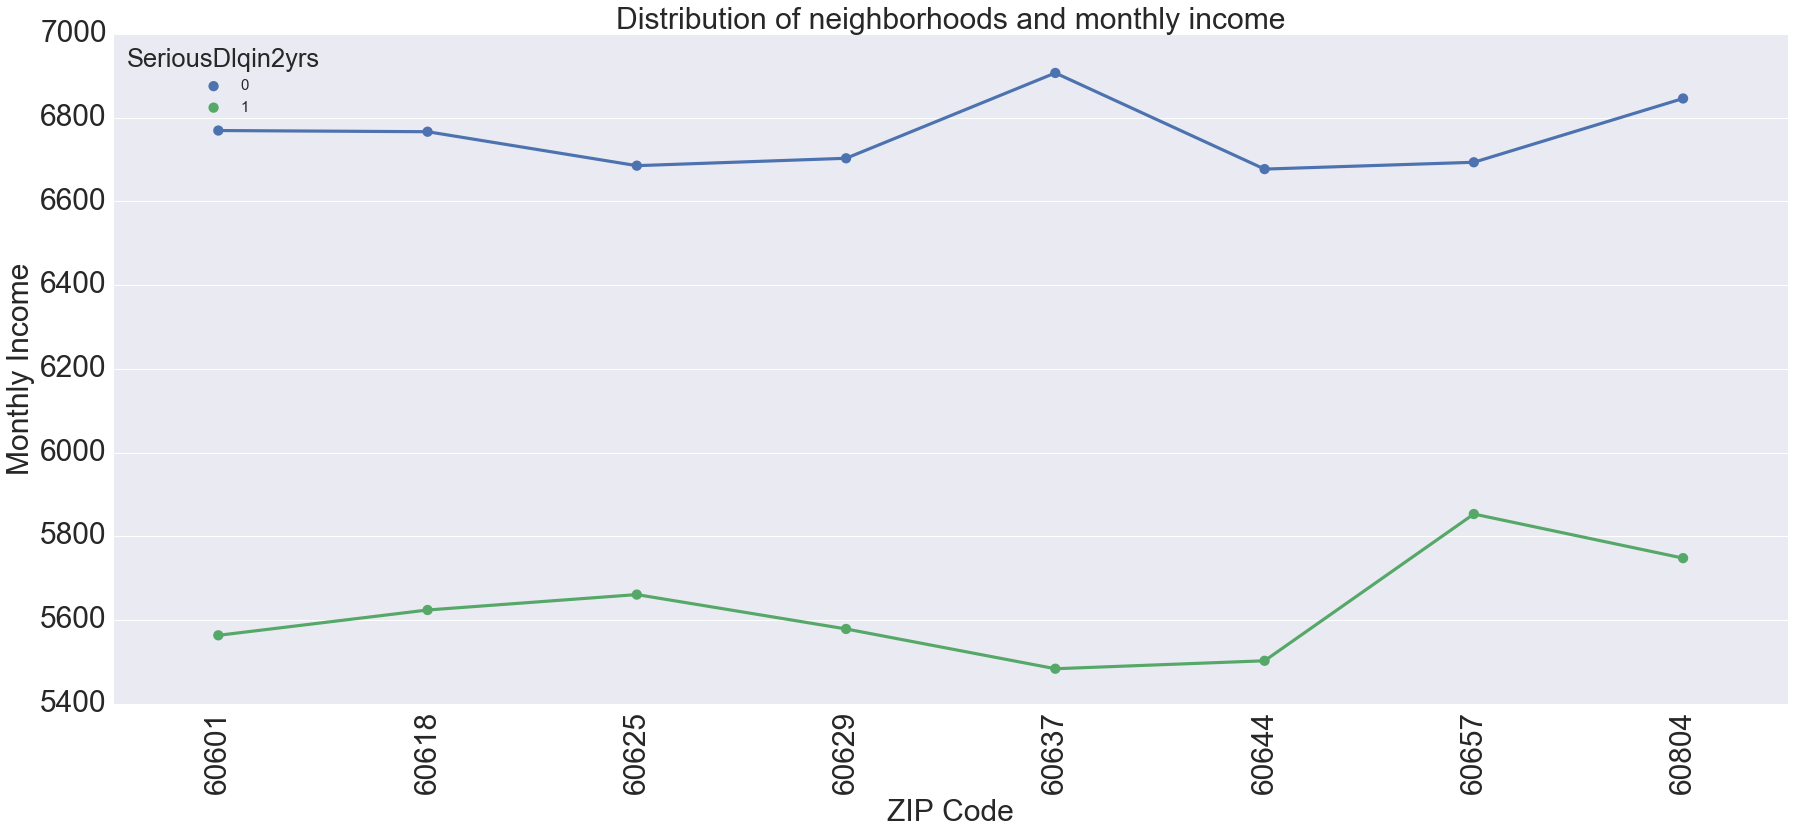

In [12]:
#visualize results
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 20, 'legend.fontsize': 15.0, 'axes.titlesize': 30, "figure.figsize": [30, 12]}
sns.set(rc=rc)
g = sns.pointplot(ci = None, x = raw_df["zipcode"], y = raw_df['MonthlyIncome'], hue = raw_df["SeriousDlqin2yrs"])
plt.xticks(rotation=90)
g.set(xlabel = "ZIP Code", ylabel = "Monthly Income", title = "Distribution of neighborhoods and monthly income")

#### *Looking at the chart above, we can find that in every neighborhood, people who will not experience financial distress earn $2,000 on average more than those who will experience financial distress. In 60637, there is a huge gap between the rich and the poor.* 

#### 2.5 Difference between two groups of people
Select some continuous variables (age, income, debt ratio, etc.) and group by type (will/will not experience financial distress), calculate the mean of these variables, and see if there is a difference between the two groups of people. Then plot anything that is interesting.

In [22]:
raw_df[['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age','NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents',
       'agegroup']].groupby(['SeriousDlqin2yrs']).mean().reset_index()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,6.168855,52.751375,0.280109,357.151168,6747.837774,8.493620,0.135225,1.020368,0.126666,0.743417
1,1,4.367282,45.926591,2.388490,295.121066,5630.826493,7.882306,2.091362,0.988530,1.828047,0.948208


#### *People with lower balance on credit cards, with lower monthly income, who are younger and more likely to past due, are more likely to experience financial distress.*

### 3. Handling Missing Values

In [91]:
#function to print the number of missing values and what variables they belong to
def print_null_freq(df):
    """
    for a given DataFrame, calculates how many values for 
    each variable is null and prints the resulting table to stdout
    """
    df_lng = pd.melt(df)
    null_variables = df_lng.value.isnull()
    print(str(null_variables.sum()) + " values are missing")
    return pd.crosstab(df_lng.variable, null_variables)
print_null_freq(raw_df)

33655 values are missing


value,False,True
variable,,
DebtRatio,150000,0
MonthlyIncome,120269,29731
NumberOfDependents,146076,3924
NumberOfOpenCreditLinesAndLoans,150000,0
NumberOfTime30-59DaysPastDueNotWorse,150000,0
NumberOfTime60-89DaysPastDueNotWorse,150000,0
NumberOfTimes90DaysLate,150000,0
NumberRealEstateLoansOrLines,150000,0
PersonID,150000,0


33655 values are missing in monthly income and the number of dependents. 
useful code: https://github.com/yhat/DataGotham2013/blob/master/notebooks/3%20-%20Importing%20Data.ipynbSome 

For number_of_dependents, I'll **fill na with zero**. If someone didn't specify how many dependents they had then let's assume it's becasue they don't have any to begin with. 

In [92]:
#function to fill in missing values
def fillin_na(df, variable, kind):
    """
    for a variable in a given DataFrame, fill in missing values with zero, mean, or median
    """
    var = df[variable]
    if kind == 'zero':
        var = var.fillna(0)
    if kind == 'mean':
        var = var.fillna(var.mean())
    if kind == 'median':
        var = var.fillna(var.median())
    df[variable] = var 
    return df
fillin_na(raw_df, 'NumberOfDependents', 'zero')

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,60629,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,60637,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,60625,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,60804,0,46.000000,NaN,2,0,0,0,0.0
9,10,0,0.189169,57,60629,0,0.606291,23684.0,9,0,4,0,2.0


#### For na in monthlyincome, we can use the function above to fill with median. However, for this assignment, I follow the tutorial on github that uses the KNearestNeighbors algorithm to impute data, then replace missing values with values that come from similar records in our dataset that aren't null

#### Cross Validation
split our data into 2 groups: training and test. we'll use the training set to calibrate our model and then use the test set to evaluate how effective it is. I'll use the same training/testing dataset in step 5&6

In [94]:
is_test = np.random.uniform(0, 1, len(raw_df)) > 0.75
train = raw_df[is_test==False]
test = raw_df[is_test==True]

In [95]:
len(train), len(test)

(112814, 37186)

#### Calibrate the imputation with the training set

In [96]:
income_imputer = KNeighborsRegressor(n_neighbors=1)

#split our data into 2 groups; data containing nulls and data 
# not containing nulls we'll train on the latter and make
# 'predictions' on the null data to impute monthly_income
train_w_monthly_income = train[train.MonthlyIncome.isnull()==False]
train_w_null_monthly_income = train[train.MonthlyIncome.isnull()==True]

In [97]:
train_w_monthly_income.corr()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,1.000000,0.004894,0.001053,0.005468,-0.003947,-0.001857,0.000272,0.001296,0.003612,-0.002575,-0.001222,-0.002108,-0.001628
SeriousDlqin2yrs,0.004894,1.000000,-0.002734,-0.103200,0.008432,0.120534,-0.005886,-0.020297,-0.028096,0.109074,-0.003947,0.091526,0.046716
RevolvingUtilizationOfUnsecuredLines,0.001053,-0.002734,1.000000,-0.004083,-0.003764,-0.001024,-0.001371,0.008336,-0.009993,-0.001152,0.007346,-0.000934,0.002573
age,0.005468,-0.103200,-0.004083,1.000000,0.004857,-0.048312,-0.005025,0.036313,0.189404,-0.047437,0.067224,-0.042522,-0.207697
zipcode,-0.003947,0.008432,-0.003764,0.004857,1.000000,0.007124,0.007022,0.004721,-0.002429,0.007188,-0.002171,0.006771,-0.001958
NumberOfTime30-59DaysPastDueNotWorse,-0.001857,0.120534,-0.001024,-0.048312,0.007124,1.000000,-0.001843,-0.009997,-0.045732,0.976187,-0.025822,0.980873,0.004719
DebtRatio,0.000272,-0.005886,-0.001371,-0.005025,0.007022,-0.001843,1.000000,-0.029304,0.012856,-0.003153,0.024259,-0.002066,0.008265
MonthlyIncome,0.001296,-0.020297,0.008336,0.036313,0.004721,-0.009997,-0.029304,1.000000,0.088275,-0.012432,0.120481,-0.010689,0.062492
NumberOfOpenCreditLinesAndLoans,0.003612,-0.028096,-0.009993,0.189404,-0.002429,-0.045732,0.012856,0.088275,1.000000,-0.073605,0.425496,-0.062676,0.035858
NumberOfTimes90DaysLate,-0.002575,0.109074,-0.001152,-0.047437,0.007188,0.976187,-0.003153,-0.012432,-0.073605,1.000000,-0.041355,0.989695,-0.001793


In [99]:
train_w_monthly_income.corr().ix[:,7]

PersonID                                0.001296
SeriousDlqin2yrs                       -0.020297
RevolvingUtilizationOfUnsecuredLines    0.008336
age                                     0.036313
zipcode                                 0.004721
NumberOfTime30-59DaysPastDueNotWorse   -0.009997
DebtRatio                              -0.029304
MonthlyIncome                           1.000000
NumberOfOpenCreditLinesAndLoans         0.088275
NumberOfTimes90DaysLate                -0.012432
NumberRealEstateLoansOrLines            0.120481
NumberOfTime60-89DaysPastDueNotWorse   -0.010689
NumberOfDependents                      0.062492
Name: MonthlyIncome, dtype: float64

In [101]:
cols = ['NumberRealEstateLoansOrLines', 'NumberOfOpenCreditLinesAndLoans']
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.MonthlyIncome)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

#### Replace the mising values

In [102]:
new_values = income_imputer.predict(train_w_null_monthly_income[cols])

In [103]:
train_w_null_monthly_income['MonthlyIncome'] = new_values
new_values

/Users/cuiyanning/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([  8000.,   8006.,   9633., ...,   3500.,  11783.,   4532.])

In [104]:
#combine the data back together
train = train_w_monthly_income.append(train_w_null_monthly_income)
len(train)

112814

In [105]:
test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test.head()

/Users/cuiyanning/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,monthly_income_imputed
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0,4373.0
19,20,0,0.602794,25,60657,0,0.065868,333.0,2,0,0,0,0.0,8006.0
29,30,0,0.392995,58,60625,2,0.436103,5500.0,15,0,1,0,0.0,7000.0
31,32,0,1.000000,24,60657,0,0.472703,750.0,1,0,0,0,0.0,2479.0
33,34,0,0.186869,57,60625,0,0.313812,7000.0,9,0,2,0,0.0,7716.0


In [106]:
test['MonthlyIncome'] = np.where(test.MonthlyIncome.isnull(), test.monthly_income_imputed,
                                  test.MonthlyIncome)

/Users/cuiyanning/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [113]:
#check if df no longer contains nulls
print_null_freq(test)

0 values are missing


value,False
variable,
DebtRatio,37186
MonthlyIncome,37186
NumberOfDependents,37186
NumberOfOpenCreditLinesAndLoans,37186
NumberOfTime30-59DaysPastDueNotWorse,37186
NumberOfTime60-89DaysPastDueNotWorse,37186
NumberOfTimes90DaysLate,37186
NumberRealEstateLoansOrLines,37186
PersonID,37186


In [114]:
#check if df no longer contains nulls
print_null_freq(train)

0 values are missing


value,False
variable,
DebtRatio,112814
MonthlyIncome,112814
NumberOfDependents,112814
NumberOfOpenCreditLinesAndLoans,112814
NumberOfTime30-59DaysPastDueNotWorse,112814
NumberOfTime60-89DaysPastDueNotWorse,112814
NumberOfTimes90DaysLate,112814
NumberRealEstateLoansOrLines,112814
PersonID,112814


### 4. Generate Features/Predictors: For this assignment, you should write one function that can discretize a continuous variable and one function that can take a categorical variable and create binary/dummy variables from it. Apply them to at least one variable each in this data.

#### 4.1. function that can discretize a continuous variable

I define a function to generate age groups based on age. (Recall: it has already been used in step 2: exploring data)

In [84]:
#define a function to generate age groups
def agegroup(df):
    labels = [ "{0} - {1}".format(i, i + 9) for i in range(0, 110, 10) ]
    agegroup = pd.cut(df, range(0, 115, 10), right=False, labels=labels)
    return agegroup
#apply agegroup function
raw_df['agegroup'] = raw_df[['age']].apply(agegroup)
raw_df.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,agegroup
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0,40 - 49
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0,40 - 49
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0,30 - 39
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0,30 - 39
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0,40 - 49


#### 4.2  function that can take a categorical variable and create binary/dummy variables from it

##### I use pandas 'get_dummies' to convert a categorical variable (number of dependents) into a binary variable

In [149]:
pd.get_dummies(raw_df['NumberOfDependents'])

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,13.0,20.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Build Classifier: KNN, RandomForest, GradientBoosting

I will use training dataset to build classifier, then evaluate the classifier on testing data

#### 5.1 KNN Classifier

In [198]:
features = ['RevolvingUtilizationOfUnsecuredLines',
       'age', 'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

prediction = 'SeriousDlqin2yrs'

def classifier(kind, train, test):
    if kind == 'KNN':
        clf = KNeighborsClassifier(n_neighbors=13)
    if kind == 'RF':
        clf = RandomForestClassifier()
    if kind == 'GB':
        clf = GradientBoostingClassifier()
    clf.fit(train[features], train[prediction])
    probs = clf.predict_proba(test[features])
    return(probs) 

(array([  2.98880000e+04,   5.05200000e+03,   1.64500000e+03,
          4.38000000e+02,   1.07000000e+02,   2.20000000e+01,
          9.00000000e+00,   1.10000000e+01,   9.00000000e+00,
          5.00000000e+00]),
 array([ 0.        ,  0.08461538,  0.16923077,  0.25384615,  0.33846154,
         0.42307692,  0.50769231,  0.59230769,  0.67692308,  0.76153846,
         0.84615385]),
 <a list of 10 Patch objects>)

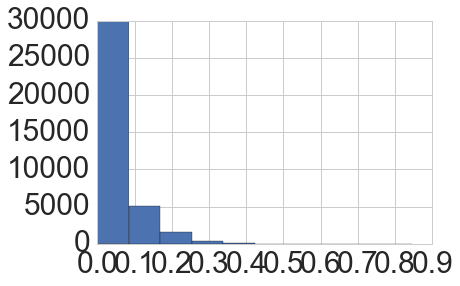

In [194]:
#apply the function
KNN_probs = classifier('KNN', train, test)

#plot a histogram of probabilities
KNN_prob_true = KNN_probs[::,1]
pl.hist(KNN_prob_true)

#### 5.2 Random Forest

(array([  2.52850000e+04,   6.12600000e+03,   3.62300000e+03,
          5.00000000e+00,   8.21000000e+02,   8.98000000e+02,
          2.26000000e+02,   2.00000000e+00,   1.28000000e+02,
          7.20000000e+01]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

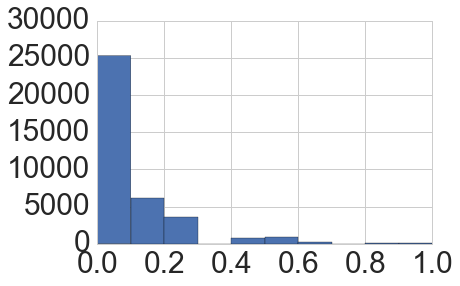

In [195]:
#apply the function
RF_probs = classifier('RF', train, test)

#plot a histogram of probabilities
RF_prob_true = RF_probs[::,1]
pl.hist(RF_prob_true)

#### 5.3 Gradient Boosting

(array([  3.15390000e+04,   2.48000000e+03,   1.05200000e+03,
          6.99000000e+02,   4.86000000e+02,   4.12000000e+02,
          2.78000000e+02,   1.66000000e+02,   7.00000000e+01,
          4.00000000e+00]),
 array([ 0.00631611,  0.1003853 ,  0.19445449,  0.28852368,  0.38259287,
         0.47666206,  0.57073125,  0.66480043,  0.75886962,  0.85293881,
         0.947008  ]),
 <a list of 10 Patch objects>)

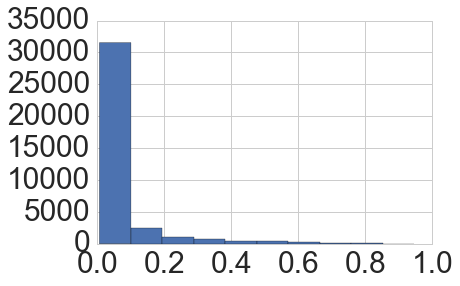

In [196]:
#apply the function
GB_probs = classifier('GB', train, test)

#plot a histogram of probabilities
GB_prob_true = GB_probs[::,1]
pl.hist(GB_prob_true)

### 6. Evaluate Classifier: Confusion Matrix and ROC Curve on test data

#### 6.1 Confusion Matrix

In [211]:
def confustionmatrix(kind, train, test):
    if kind == 'KNN':
        clf = KNeighborsClassifier(n_neighbors=13)
    if kind == 'RF':
        clf = RandomForestClassifier()
    if kind == 'GB':
        clf = GradientBoostingClassifier()
    clf.fit(train[features], train[prediction])
    matrix = print(confusion_matrix(test[prediction], clf.predict(test[features])))
    report = print (classification_report(test[prediction], clf.predict(test[features]), labels=[0, 1]))
    return(matrix, report) 

In [212]:
confustionmatrix('KNN', train, test)

[[34764    10]
 [ 2388    24]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     34774
          1       0.71      0.01      0.02      2412

avg / total       0.92      0.94      0.91     37186



(None, None)

*The matrix tells us that there are 34764 true negatives and 24 true positives. There are 2398 results mislabled. The KNN classifier is much better at predicting non-financial distressed population, while it only successfully predicts 24/2388 financial distressed population.*

In [213]:
confustionmatrix('RF', train, test)

[[34370   404]
 [ 1999   413]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     34774
          1       0.51      0.17      0.26      2412

avg / total       0.92      0.94      0.92     37186



(None, None)

In [214]:
confustionmatrix('GB', train, test)

[[34438   336]
 [ 1920   492]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     34774
          1       0.59      0.20      0.30      2412

avg / total       0.92      0.94      0.93     37186



(None, None)

#### 6.2 ROC Curve
A ROC Curve plots the False Postive Rate (fpr) vs. the True Positive Rate (tpr) for a classifier

I take the function in github repo to plot my curve.

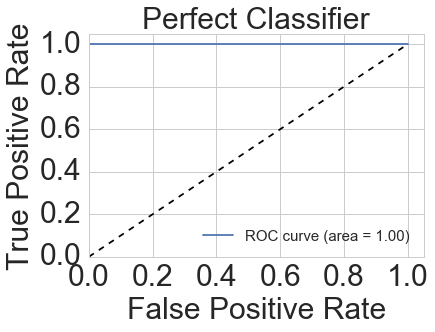

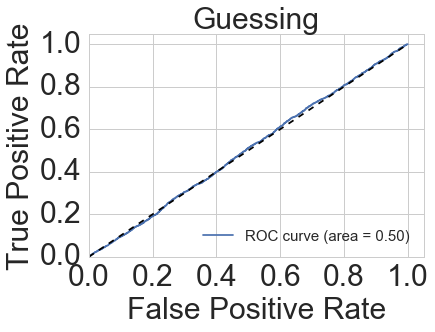

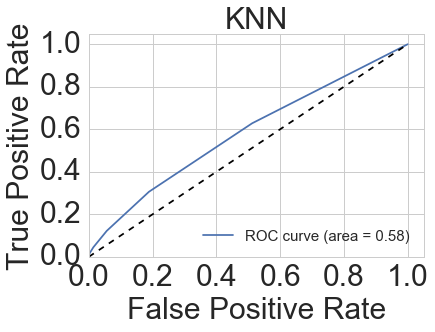

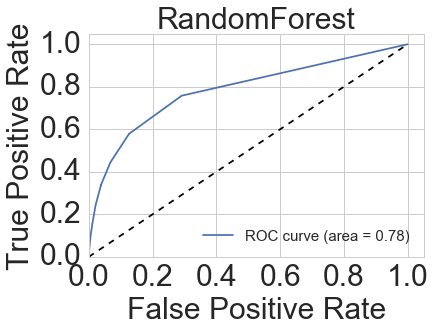

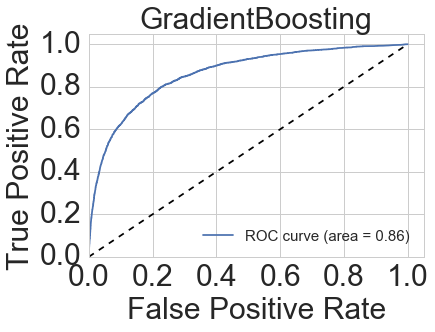

In [215]:
def plot_roc(name, probs):
    fpr, tpr, thresholds = roc_curve(test['SeriousDlqin2yrs'], probs)
    roc_auc = auc(fpr, tpr)
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.05])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(name)
    pl.legend(loc="lower right")
    pl.show()

plot_roc("Perfect Classifier", test['SeriousDlqin2yrs'])
plot_roc("Guessing", np.random.uniform(0, 1, len(test['SeriousDlqin2yrs'])))

#[::,1] selects the 2nd column of the numpy array
plot_roc("KNN", KNN_probs[::,1])
plot_roc("RandomForest", RF_probs[::,1])
plot_roc("GradientBoosting", GB_probs[::,1])

#### RandomForest is much better than KNN classifier. 0.78 beats 0.58, and GradientBoosting performs the best

### ---END---